# Who should you take in the NFL draft? - Data Exploration

## What does the data look like?

Now that we have the data scraped from the web (see web scrape notebook), we can do some small exploration to see what the data looks like. First, of course, import the usual libraries plus override some matplotlib defaults:

In [12]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn import linear_model, ensemble, decomposition
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

%config InlineBackend.figure_format='svg'
mpl.rcParams['figure.figsize'] = (10.0, 8.0)
plt.style.use('seaborn-ticks')

With the following pandas command we can read in the data we scraped in the web scrape notebook:

In [5]:
df = pd.read_csv('/Users/richard/data/NFL/NFL.csv', index_col='idx')

# I didn't mean to take kicker data, just the first two rows to have the column information,
# so I'm going to drop those positions:

df = df.drop(df[df['Pos']=='K'].index)
df = df.drop(df[df['Pos']=='P'].index)

Pandas has a useful feature to give summary statistics for a given dataframe. The command is describe(), where I pass the option include= 'all' so that we have a summary for all data types, not just numerics. Also, I drop some columns which I don't really care for, which clutters the display:

In [66]:
drop_cols = ['Year', 'Player','Probowl']

#df.drop(drop_cols, 1).describe(include='all')

,Pos,School,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,Height_inches
count,3374,3374,3374.000000,3363.000000,2670.000000,2337.000000,2654.000000,2256.000000,2291.000000,3374.000000
unique,14,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,WR,Southern California,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,502,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,242.898044,4.735225,33.461423,21.535302,114.865863,7.224880,4.349014,73.703616
std,NaN,NaN,43.269352,0.280709,4.023955,6.413189,8.595756,0.382225,0.247746,2.682730
min,NaN,NaN,149.000000,4.240000,19.500000,2.000000,88.000000,6.420000,3.730000,65.000000
25%,NaN,NaN,208.000000,NaN,NaN,NaN,NaN,NaN,NaN,72.000000
50%,NaN,NaN,236.000000,NaN,NaN,NaN,NaN,NaN,NaN,74.000000
75%,NaN,NaN,271.000000,NaN,NaN,NaN,NaN,NaN,NaN,76.000000


Ok, that's pretty interesting. This tells us quite a lot of information. For example, check out the Heigh_inches column. This column tells us the mean, max and min, among other things for the height of the players. Let's see, who's the tallest person that's gone to the Combine?

In [38]:
df[df['Height_inches'] == df['Height_inches'].max()]

,Year,Player,Pos,School,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,Height_inches,Probowl
idx,,,,,,,,,,,,,
1307,2006.0,Dennis Roland,OT,Georgia,328.0,5.28,NaN,19.0,NaN,NaN,NaN,82.0,False


Ok, so turns out that Dennis Roland, whom I've never hear of before, was the tallest person at the Combine at almost 6-10, pretty tall guy. He was drafted in 2006, I wonder where he is now-- guess we can check out his Wikipedia to get more info https://en.wikipedia.org/wiki/Dennis_Roland .

How about Vertical? Who could jump the highest in our entire data set?

In [43]:
df[df['Vertical'] == df['Vertical'].max()]

,Year,Player,Pos,School,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,Height_inches,Probowl
idx,,,,,,,,,,,,,
1156,2005.0,Cameron Wake,OLB,Penn State,236.0,4.65,45.5,20.0,130.0,7.12,4.11,75.0,True


Alright, a Miami Dolphin great. Good to see he's the person to log the highest jump in the Combine.

## Analysis on groupings

Suppose we want to know which school shows up the most in our Combine data. In pandas, the groupby command takes care of this for us. Notice, that if we want to know the frequency count of our dataset when grouped in certain ways, in pandas one uses the size() function instead of the usual count() function from SQL. This could be a bit misleading for those coming from SQL to pandas..

But, without further ado..

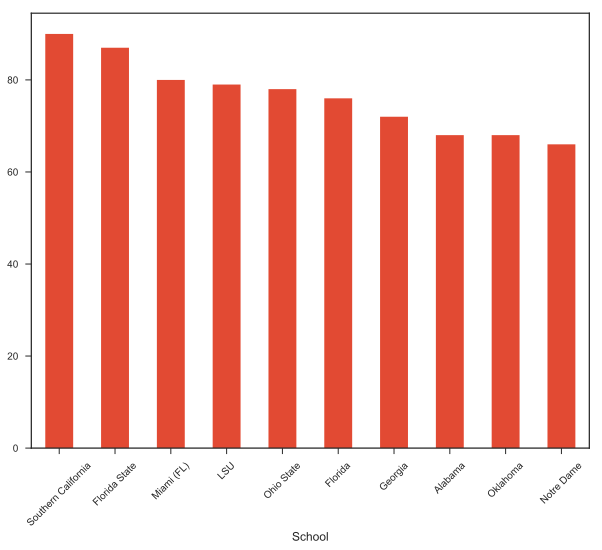

In [13]:
df.groupby('School').size().sort_values(ascending=False).head(n=10).plot(kind='bar', rot=45)

Well, makes sense that Southern California churns out quite a lot of drafted players. But, do they produce the most probowlers?

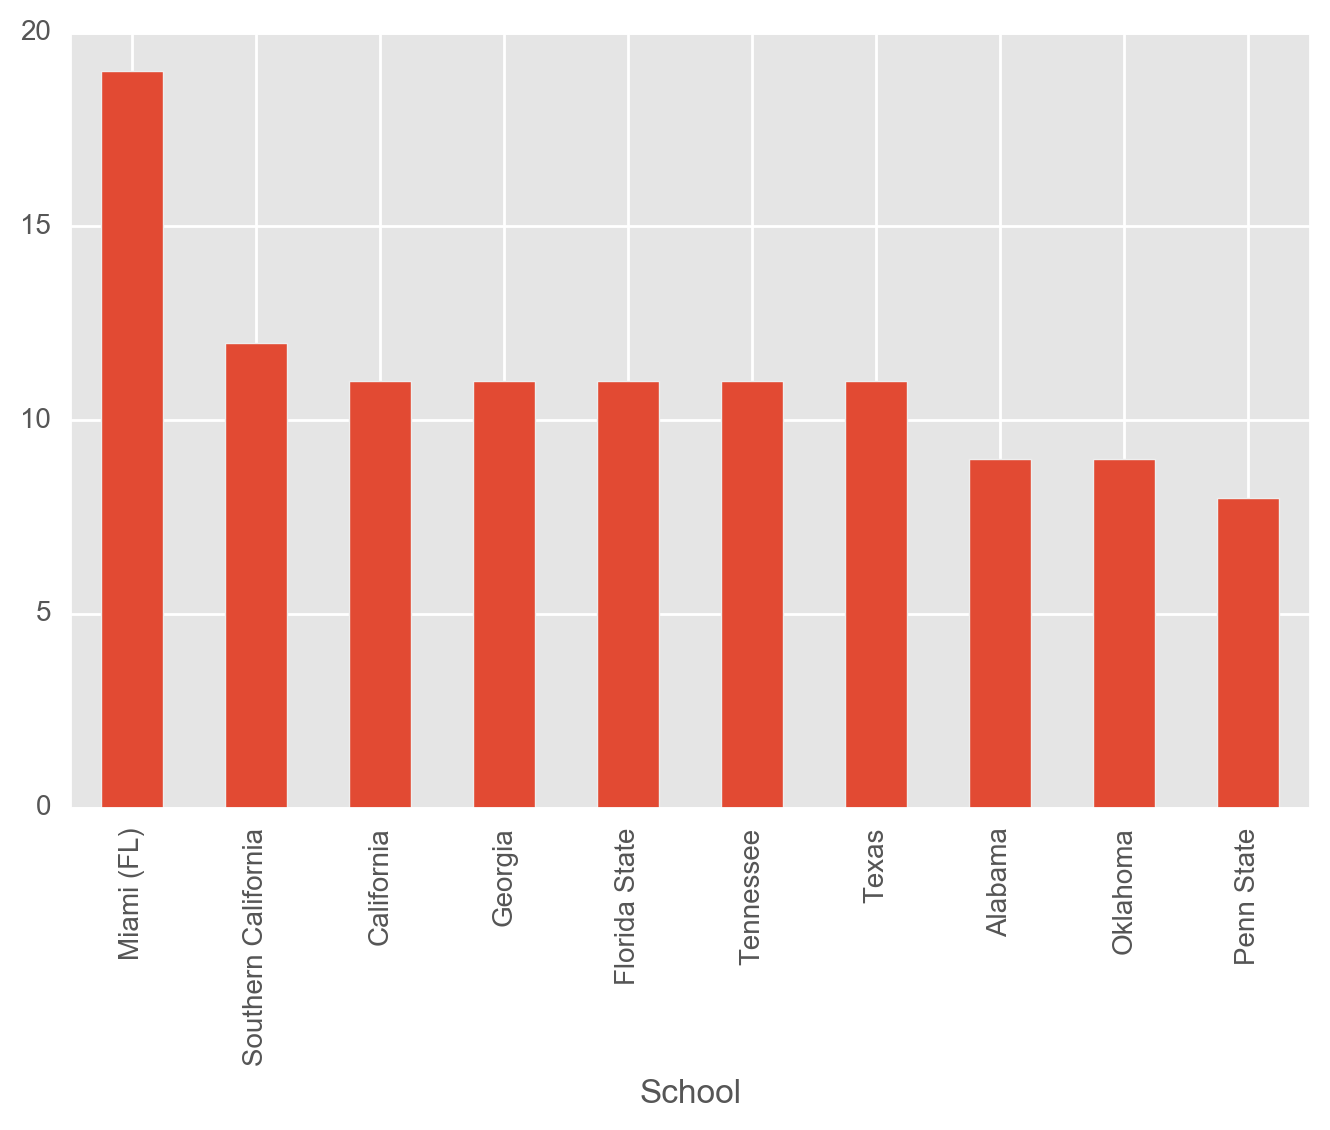

In [69]:
df[df['Probowl'] == True].groupby('School').size().sort_values(ascending=False).head(n=10).plot(kind='bar');

Aww damn. Having gone to Florida International University for undergrad, I'm not terribly happy with this outcome but data is data-- I'll have to live with it. 

It turns out that University of Miami produces the most probowlers! Well, maybe at least I can have some home pride for this one..

By the numbers, which position is best represented in our data set? And, how about of those who made it and didn't make it to the probowl?

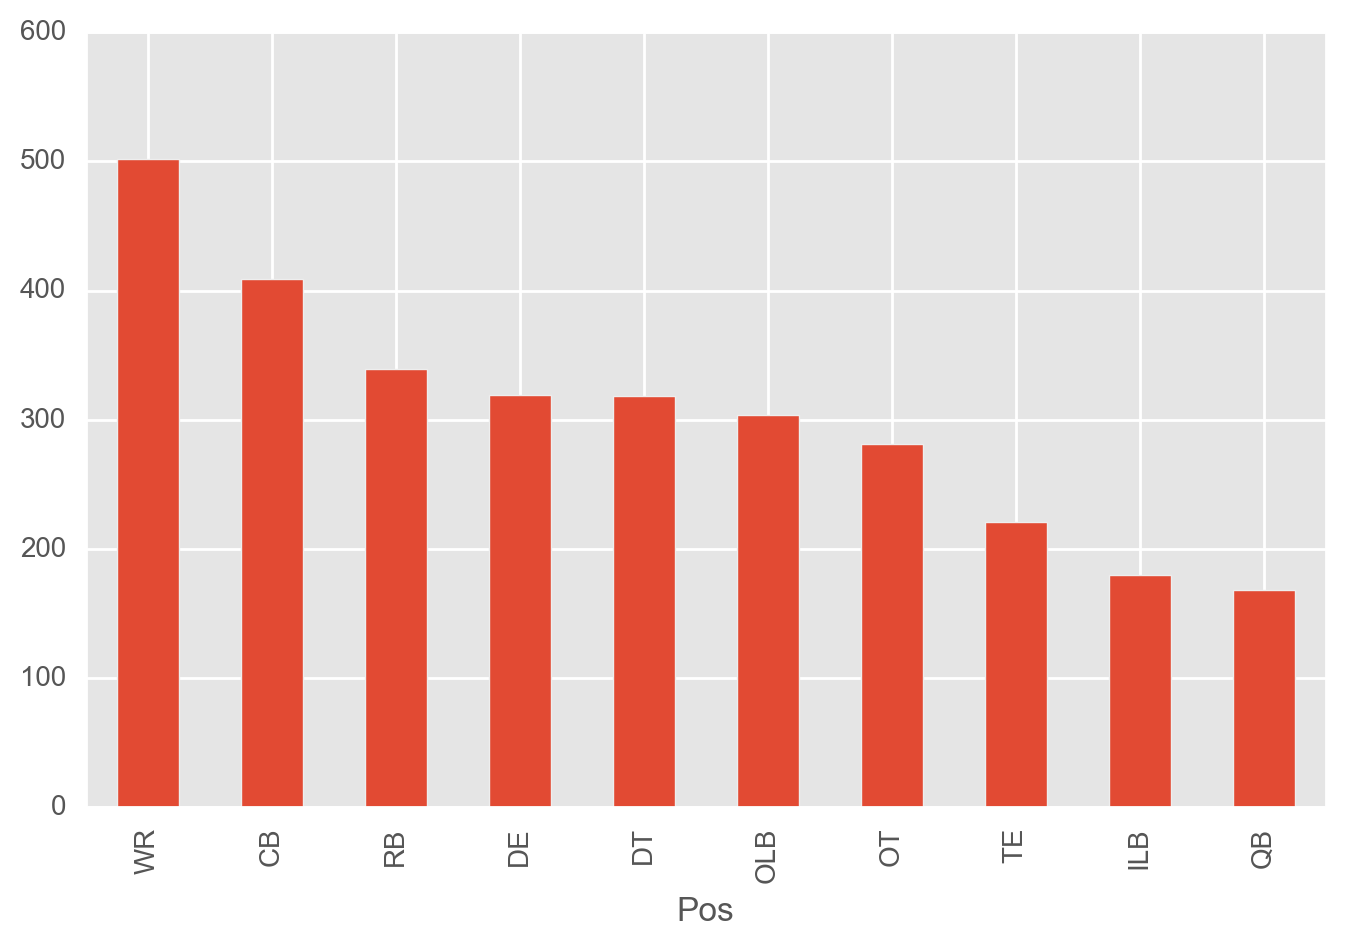

In [70]:
df.groupby('Pos').size().sort_values(ascending=False).head(n=10).plot(kind='bar');

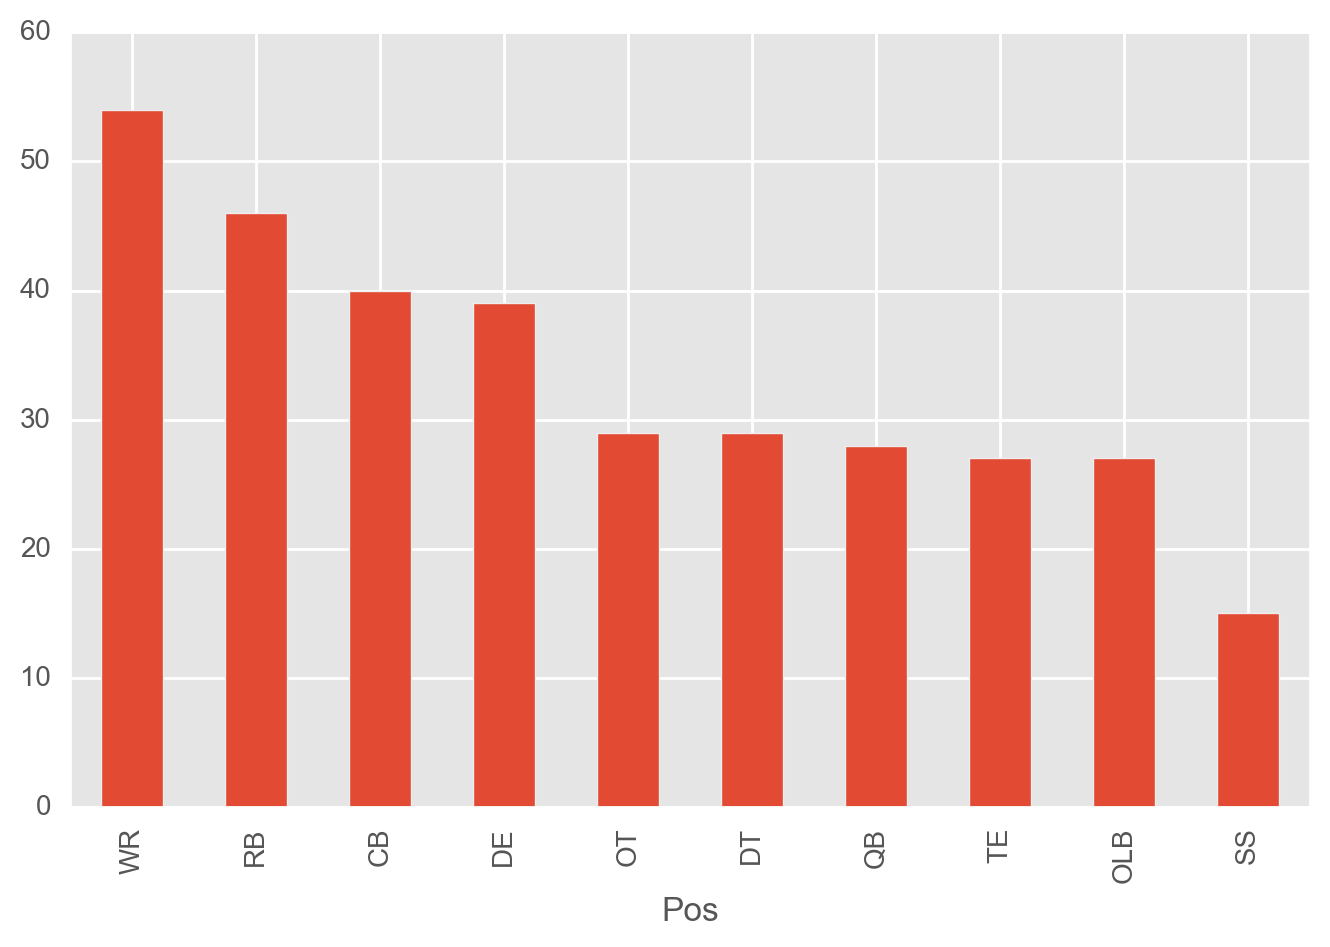

In [71]:
df[df['Probowl']==True].groupby('Pos').size().sort_values(ascending=False).head(n=10).plot(kind='bar');

We don't see much difference there. With some of the top places getting shuffled around in the different plots, it seems wide receivers have pretty good success at getting into the probowl.. Or do they?

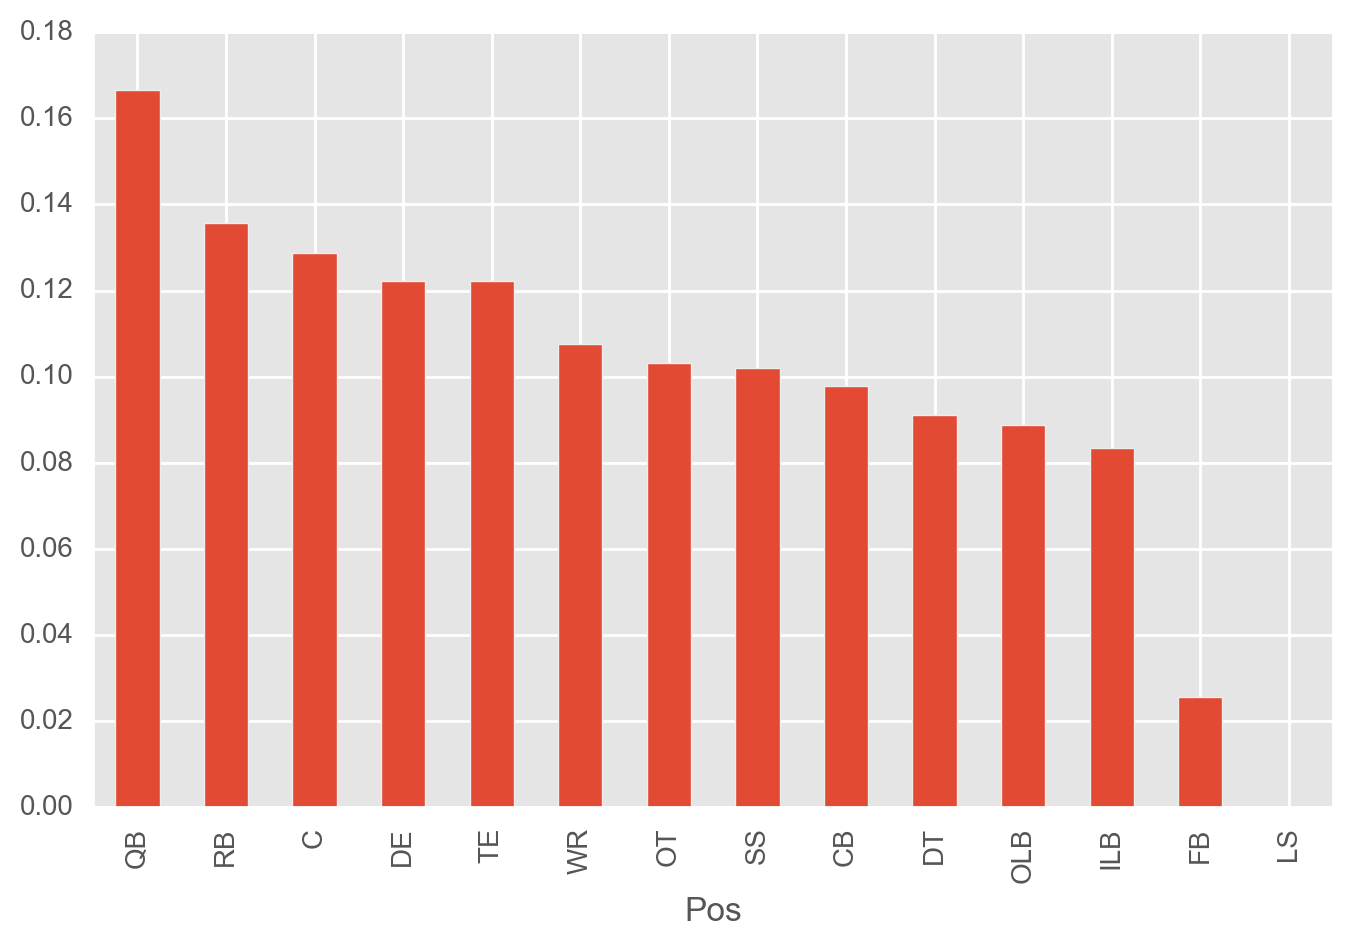

In [73]:
((df[df['Probowl']==True].groupby('Pos').size())/(df.groupby('Pos').size())).sort_values(ascending=True).sort_values(ascending=False).plot(kind='bar');

This is a much more telling plot. We can divide the number of probowlers within each position category to see which position has the highest shot at getting into the probowl. Turns if you want to go to the probowl, you've got the best odds if you're a quarterback, punter or running back!

Also, interestingly, we see WR drop down the ranks.

Now with the idea in mind that we will be training on who has gone on to the probowl, and who has not made it (yet?), we can take the ratio, by position, of probowl instances vs non-probowl instances: 

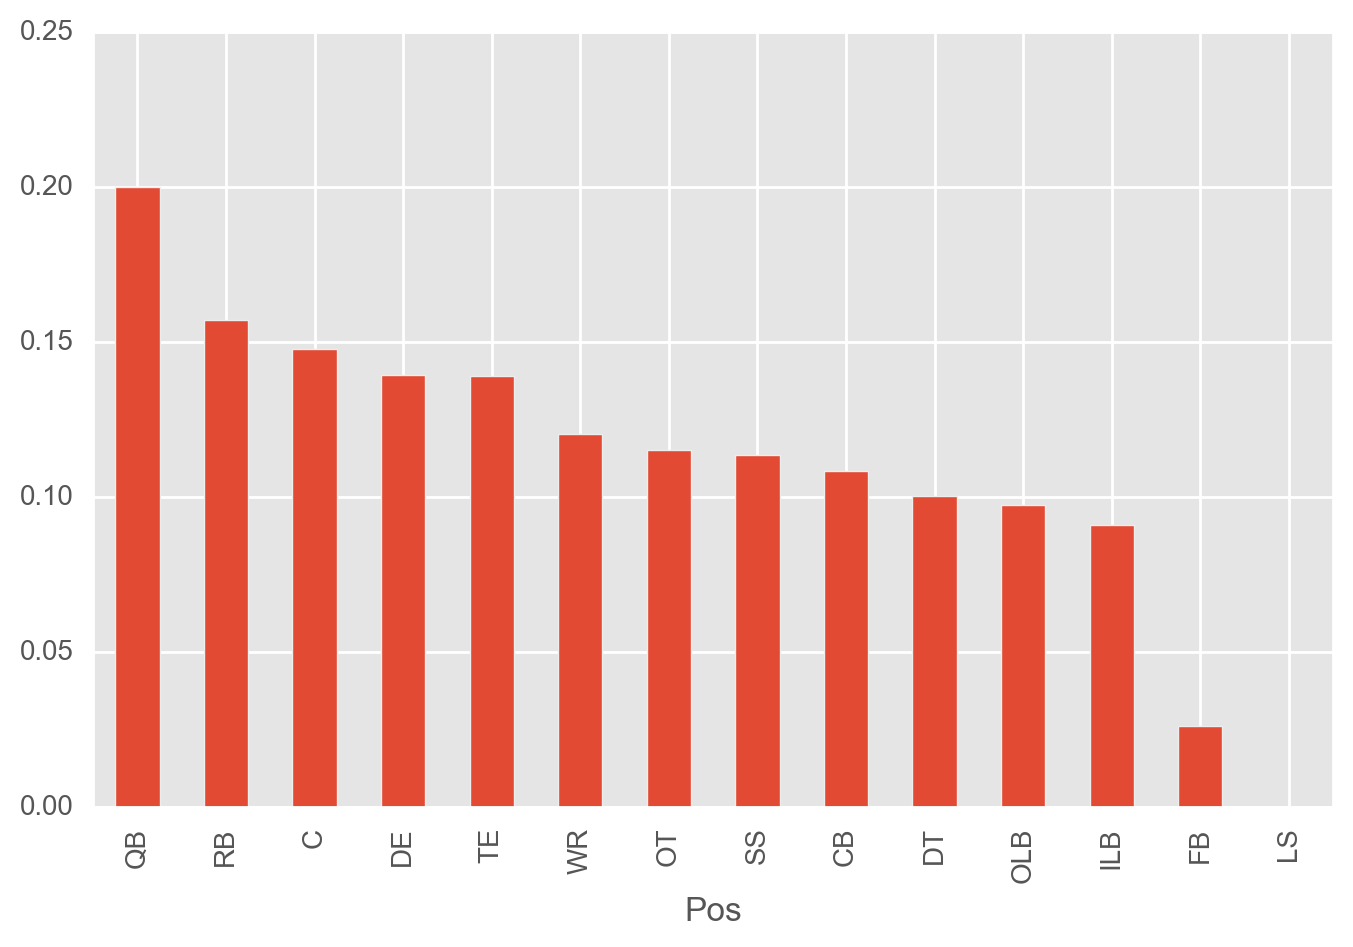

In [74]:
((df[df['Probowl']==True].groupby('Pos').size())/(df[df['Probowl']==False].groupby('Pos').size())).sort_values(ascending=True).sort_values(ascending=False).plot(kind='bar');

Not much difference there.. except that for running backs we have a lot more observations (rows) in our data, so that means more training data. That means then that training a classifier to pick running backs in the draft may work a whole lot better than QB's. We'll see what happens when we run our analysis..

## Offense vs. Defense

Is there a qualitative difference between probowlers on the difference sides of the ball? I'm not analyzing special temas in this analysis, just focusing on offense and defense for now--
to be continued..